<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
  LDA Spike 4 - Topic Visualization
</h1>

This notebook visualizes the topic model generated via Latent Dirichlet Allocation. By default the result of the Latent Dirichlet Allocation is expected to be found in the folder `Topics`. We use elementary plots (bar charts, heat map) from [Matplotlib](https://matplotlib.org/) and the [WordCloud](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) developed by [Andreas Mueller](https://github.com/amueller).

<font color="darkred" /><p/>

__This notebooks reads from your file system.__ Per default all used directories are within `~/TextData/Abgeordnetenwatch`, where `~` stands for whatever your operating system considers your home directory. To change this configuration either change the default values in the second next cell or edit [LDA Spike - Configuration.ipynb](./LDA%20Spike%20-%20Configuration.ipynb) and run it before you run this notebook.

<font color="black" /><p/>

This notebooks operates on word counts extracted from text files. In our case we retrieved these texts from www.abgeordnetenwatch.de guided by data that was made available under the [Open Database License (ODbL) v1.0](https://opendatacommons.org/licenses/odbl/1.0/) at that site.

<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import time

from pathlib import Path
import joblib

import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
%store -r own_configuration_was_read
if not('own_configuration_was_read' in globals()): raise Exception(
    '\nReminder: You might want to run your configuration notebook before you run this notebook.' + 
    '\nIf you want to manage your configuration from each notebook, just remove this check.')

%store -r project_name
if not('project_name' in globals()): project_name = 'AbgeordnetenWatch'

%store -r text_data_dir
if not('text_data_dir' in globals()): text_data_dir = Path.home() / 'TextData'

In [3]:
corpus_dir = text_data_dir / project_name / 'Corpus'
topics_dir = text_data_dir / project_name / 'Topics'

assert corpus_dir.exists(),                      'Directory should exist.'
assert corpus_dir.is_dir(),                      'Directory should be a directory.'
assert next(corpus_dir.iterdir(), None) != None, 'Directory should not be empty.'

assert topics_dir.exists(),                      'Directory should exist.'
assert topics_dir.is_dir(),                      'Directory should be a directory.'
assert next(topics_dir.iterdir(), None) != None, 'Directory should not be empty.'

## Load the results of the Latent Dirichlet Allocation

In [4]:
document_names      = joblib.load(topics_dir / 'document_names.dumb')
topics_per_document = joblib.load(topics_dir / 'topics_per_document.dumb')
words_per_topic     = joblib.load(topics_dir / 'words_per_topic.dumb')
words               = joblib.load(topics_dir / 'words.dumb')
n_topics            = topics_per_document.shape[1]

In [5]:
print('Loaded: ')
print('{} document names \n  from "{}" \n    to "{}"'.format(
    len(document_names), document_names[0], document_names[-1]))
print('For {} documents the share of each of the {} topics.'.format(
    topics_per_document.shape[0], topics_per_document.shape[1]))
print('For {} topics the probability of each of the {} words.'.format(
    words_per_topic.shape[0], words_per_topic.shape[1]))
print('{} words from "{}" to "{}"'.format(len(words), words[0], words[-1]))

Loaded: 
7696 document names 
  from "achim-kessler_die-linke_Q0001_2017-08-06_A01_2017-08-11_gesundheit" 
    to "zaklin-nastic_die-linke_Q0008_2017-10-25_A01_2018-09-24_demokratie-und-bürgerrechte"
For 7696 documents the share of each of the 100 topics.
For 100 topics the probability of each of the 19774 words.
19774 words from "Abgasnorm" to "Vogtland"


## Number of answers by deputy, party, category

In [6]:
document_names[0].split('_')

['achim-kessler',
 'die-linke',
 'Q0001',
 '2017-08-06',
 'A01',
 '2017-08-11',
 'gesundheit']

In [7]:
def plot_horizontal_barchart(dictionary):
    bars = range(len(dictionary.keys()))
    width = 10
    height = width / 10 * 0.3 * len(bars)
    plt.figure(figsize=(width, height))
    plt.barh(bars, list(dictionary.values()))
    plt.yticks(bars, list(dictionary.keys()))
    plt.show()

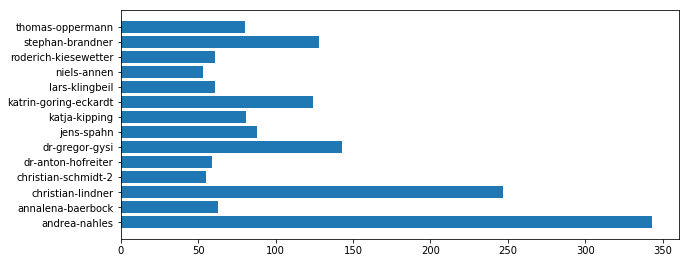

In [8]:
answering_deputies = np.array([name.split('_')[0] for name in document_names])
deputies = list(set(answering_deputies))
list.sort(deputies)

num_answers_by_deputy = {deputy : np.sum(answering_deputies == deputy) for deputy in deputies}
most_active_deputies = {deputy: num_answers for deputy, num_answers in num_answers_by_deputy.items() if num_answers > 50}

plot_horizontal_barchart(most_active_deputies)

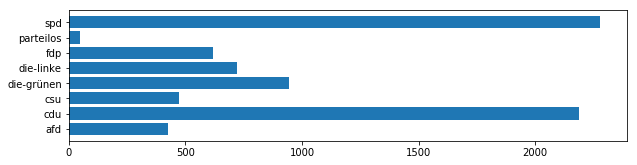

In [9]:
answering_parties = np.array([name.split('_')[1] for name in document_names])
parties = list(set(answering_parties))
list.sort(parties)

num_answers_by_party = {party : np.sum(answering_parties == party) for party in parties}

plot_horizontal_barchart(num_answers_by_party)

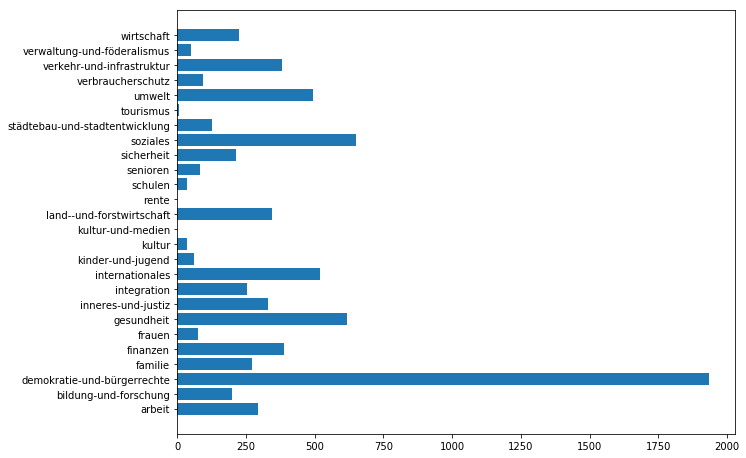

In [10]:
answer_categories = np.array([name.split('_')[6] for name in document_names])
categories = list(set(answer_categories))
list.sort(categories)

num_answers_by_category = {category : np.sum(answer_categories == category) for category in categories}

plot_horizontal_barchart(num_answers_by_category)

## Topic distribution within a category

The number of documents is too high to visualize the whole topic distribution at once. We therefore select a subset of documents by the given coarse category. One might expect that within such a subset certain topics dominate. This seems to be less the case than expected. When we later explore the documents that focus on the dominant topic within the given category, we will see, that people assigned it to other categories as well.

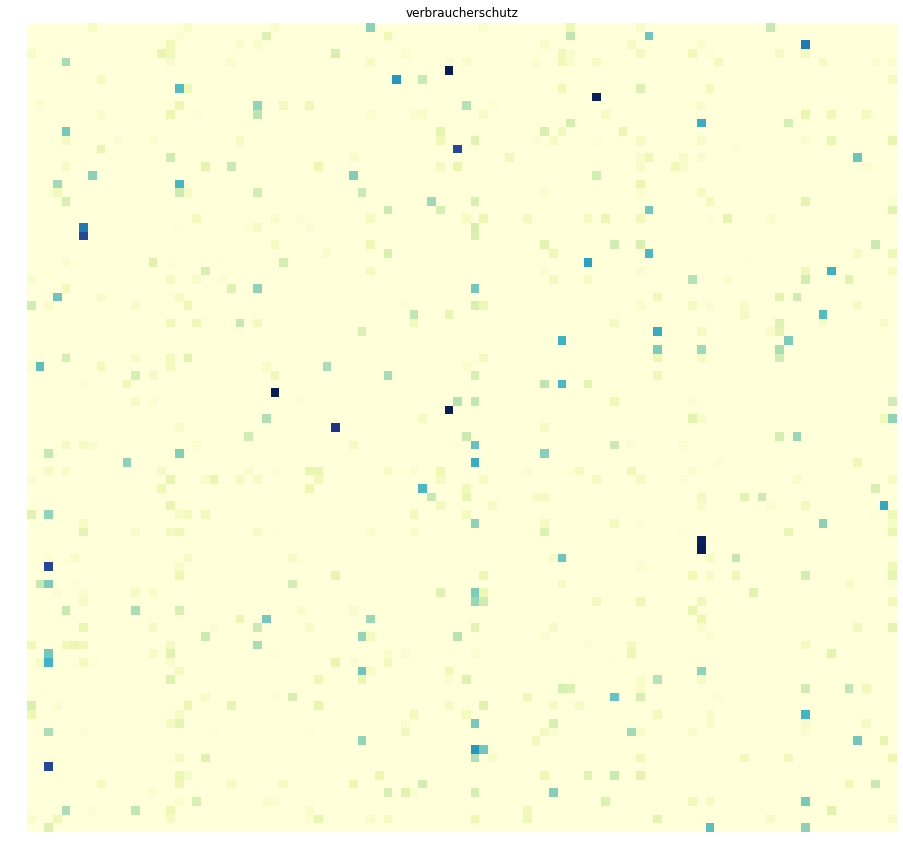

In [11]:
category = 'verbraucherschutz'
# category = 'demokratie-und-bürgerrechte'
# category = 'sicherheit'

topics_per_documents_in_category = topics_per_document[answer_categories == category, :]

width = 16
height = width / n_topics * len(topics_per_documents_in_category)

plt.figure(figsize = (width, height))
plt.title(category)
plt.axis('off')
plt.imshow(topics_per_documents_in_category, cmap='YlGnBu')
plt.show()

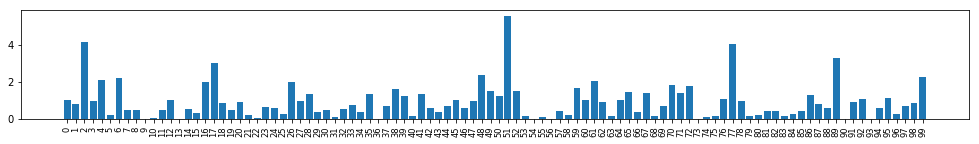

In [12]:
topic_contribution_in_category = np.sum(topics_per_documents_in_category, axis = 0)

plt.figure(figsize=(17, 2))
plt.bar(range(n_topics), topic_contribution_in_category)
plt.xticks(range(n_topics), range(n_topics), rotation = 90, fontsize='small')
plt.show()

## More visualizations for the dominant topic in the category

In [13]:
dominant_topic_in_category = np.argmax(topic_contribution_in_category)
print(dominant_topic_in_category)

51


In [14]:
show_max_words = 100
most_probable = np.argsort(words_per_topic[dominant_topic_in_category, :])[:-show_max_words-1:-1]
probabilities = words_per_topic[dominant_topic_in_category, most_probable]    

### Words and their probability

In [15]:
show_max_cummulated_probability = 0.25

for word, probability, cummulated in zip(most_probable, probabilities, probabilities.cumsum()):
    print('{:.1%} {} '.format(probability, words[word]), end = '')
    if cummulated > show_max_cummulated_probability: break

2.9% Diesel 1.9% Fahrzeug 1.5% Hersteller 1.5% müssen 1.3% Grenzwert 1.3% muss 1.2% Fahrverbote 1.1% Stadt 1.0% Automobilindustrie 1.0% Maßnahme 0.9% Bundesregierung 0.9% Verbraucher 0.9% Kosten 0.8% Autoindustrie 0.7% betroffen 0.7% Nachrüstung 0.7% einhalten 0.7% Luft 0.7% Auto 0.6% Nachrüstungen 0.6% dürfen 0.6% Dieselfahrzeuge 0.5% Euro 0.5% VW 0.5% deutsch 

### Words and their probability presented as word cloud

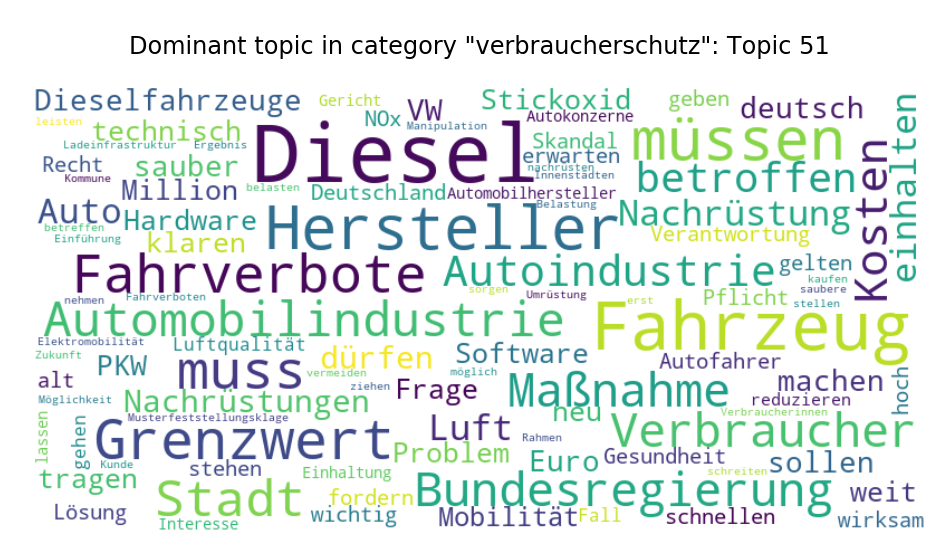

In [16]:
title_font_size = 24
max_font_size = 3 * title_font_size

wordcloud = WordCloud(background_color='white', width=800, height=400, max_font_size=max_font_size,
                      max_words = show_max_words)

image = wordcloud.generate_from_frequencies({words[w]: p for (w, p) in zip(most_probable, probabilities)})

plt.figure(figsize = (16, 10))
plt.imshow(image, interpolation='bilinear')
plt.title('\nDominant topic in category "{}": Topic {}\n'.format(category, dominant_topic_in_category), 
          fontsize=title_font_size)
plt.axis('off')
plt.show()

### Documents focussing on this topic

In [17]:
show_max_documents = 30
show_min_probability = 0.75

def url_for_answer(document_name):
    name, party, q, date, _, _, category = document_names[doc].split('_')
    url_file = corpus_dir / ('_'.join([name, party, q, date, category]) + '.url')
    try:
        return url_file.read_text()
    except:
        return 'URL not found'

topic = dominant_topic_in_category
most_focussed = np.argsort(topics_per_document[:, topic])[:-show_max_documents-1:-1]
most_focussed = [doc for doc in most_focussed if topics_per_document[doc, topic] > show_min_probability]

print('\nAnswers focussed on the dominant topic in category "{}": Topic {}\n'.format(category, topic))
for doc in most_focussed:
    probability = topics_per_document[doc, topic]
    name, party, _, _, _, date, category = document_names[doc].split('_')
    print('   {:6.2%}  {}  {:30} {:12} {}'.format(probability, date, name, party, category))
    print(10 * ' ', url_for_answer(document_names[doc]))    


Answers focussed on the dominant topic in category "verbraucherschutz": Topic 51

   98.17%  2017-08-07  christine-aschenberg-dugnus    fdp          demokratie-und-bürgerrechte
           https://www.abgeordnetenwatch.de/profile/christine-aschenberg-dugnus/question/2017-08-04/282036
   90.95%  2018-03-05  dr-rolf-mutzenich              spd          verkehr-und-infrastruktur
           https://www.abgeordnetenwatch.de/profile/dr-rolf-mutzenich/question/2018-03-02/297404
   84.87%  2017-08-07  christine-aschenberg-dugnus    fdp          demokratie-und-bürgerrechte
           https://www.abgeordnetenwatch.de/profile/christine-aschenberg-dugnus/question/2017-08-05/282271
   81.34%  2017-09-05  dr-stephan-harbarth            cdu          verkehr-und-infrastruktur
           https://www.abgeordnetenwatch.de/profile/dr-stephan-harbarth/question/2017-08-01/279884


## Words in the topics

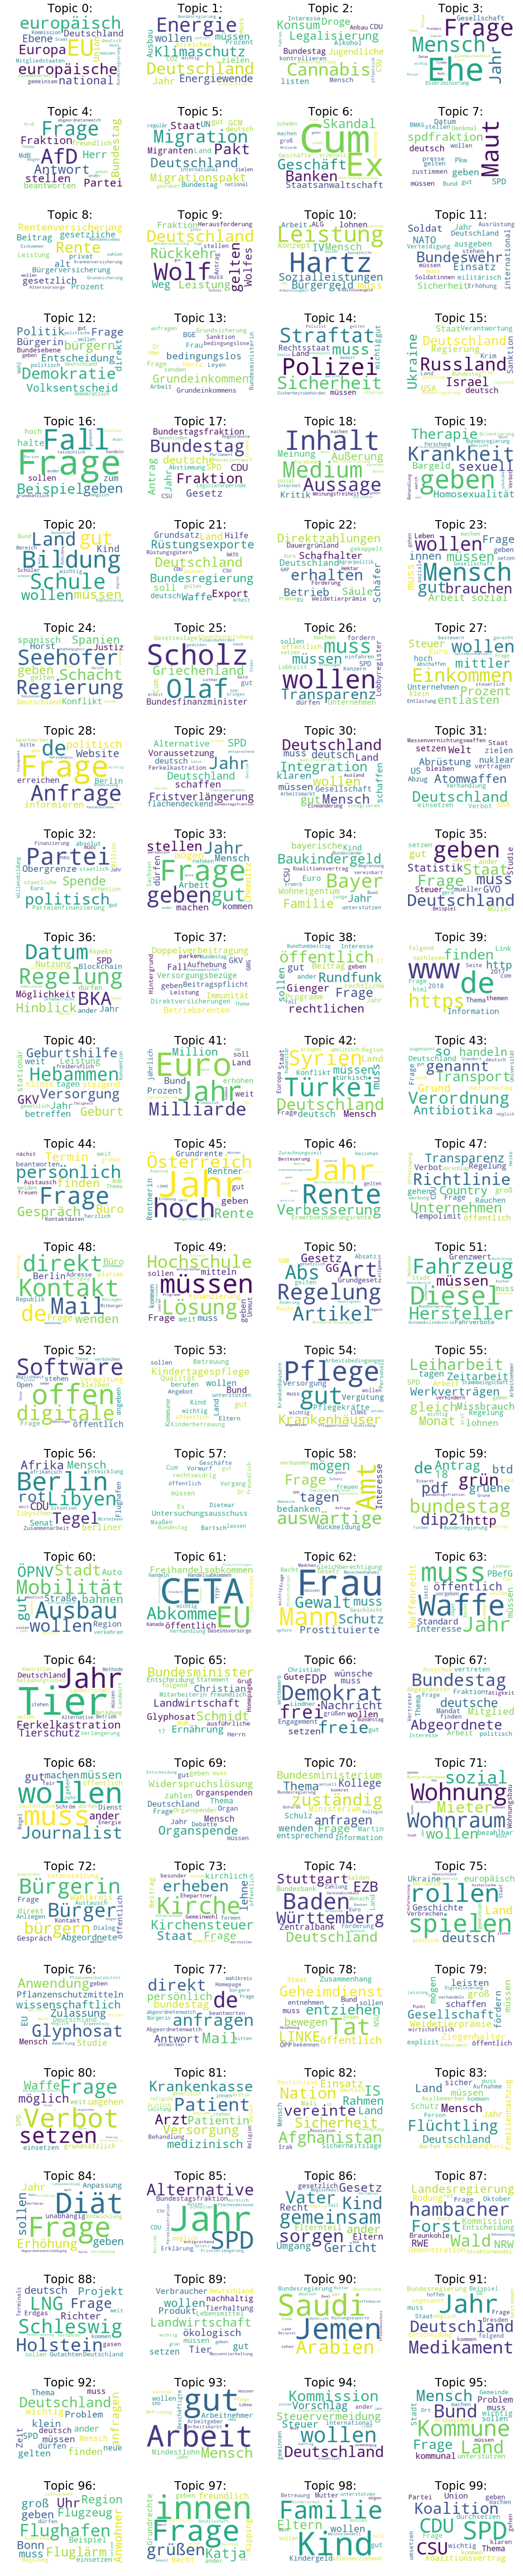

In [18]:
f, a = plt.subplots((n_topics + 3) // 4, 4)    
f.set_figheight(100)
f.set_figwidth(19)

max_words_per_topic = 18 # 12

wordcloud = WordCloud(background_color='white', max_words = max_words_per_topic,  width=300, height=200)

images = []

for topic in range(n_topics):

    most_probable = np.argsort(words_per_topic[topic, :].flatten().tolist())[:-max_words_per_topic:-1]

    probabilities = {}    
    for word in most_probable:
        probabilities[words[word]] = words_per_topic[topic, word] 
    
    image = wordcloud.generate_from_frequencies(probabilities)
    images.append(image.to_image())

    r = topic // 4
    c = topic % 4
    a[r, c].imshow(image, interpolation='bilinear')
    a[r, c].set_title('Topic {}:'.format(topic), fontsize=24)
    a[r, c].axis('off')

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; D. Speicher, T. Dong<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>